# To which extent is there some kind of relation between the dependencies between software packages (in a software packaging ecosystem) and the contributors of those packages?

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests


import sys
sys.path.append('..')

from helper import load_data , load_repo , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Cargo Dataset

In [103]:
cargo = load_repo('Cargo')
cargo_git = cargo[cargo.Repository_URL.notnull()]
cargo_git = cargo_git[cargo_git.Repository_URL.str.contains('github')].drop_duplicates(subset='Repository_URL')
repos = cargo_git[['Name','Repository_URL']].set_index('Name')

## Load Cargo packages and dependencies

In [83]:
packages, dependencies = load_data('Cargo')

join to packages and dependencies

In [89]:
packages_dependencies = packages.merge(dependencies,left_on=['package','version'], right_on=['package','version'])
packages_dependencies = packages_dependencies.drop_duplicates(subset=['package','target'],keep = 'last')
packages_dependencies.head()

,package,version,date,target,constraint
2,acacia,0.0.1,2014-12-08 12:49:37,quickcheck_macros,~0.1.5
4,acacia,0.0.2,2015-01-25 17:49:33,quickcheck,*
5,acacia,0.0.2,2015-01-25 17:49:33,nalgebra,*
19,acacia,0.1.2,2017-02-26 16:14:51,itertools,^0.5
20,acacia,0.1.2,2017-02-26 16:14:51,num,^0.1


find packages project URL

In [111]:
def find_git_url(target):
    return repos.loc[target].Repository_URL if target in repos.index else ''
packages_dependencies['target_url'] = packages_dependencies.apply(lambda row: find_git_url(row['target']),axis=1)

# Load all comments

In [119]:
depend_comt = pandas.read_csv('../data/depend/commit_comment.csv.gz').dropna().rename(columns={'comment_author_assoc':'author_assoc','user_name':'user_login','comment_created_at':'created_at'})
depend_comt['type'] = 'cmt'
depend_isue = pandas.read_csv('../data/depend/issue_comments.csv.gz')
depend_isue['type'] = 'isu'
depend_puls = pandas.read_csv('../data/depend/pulls_comments.csv.gz')
depend_puls['type'] = 'pul'
depend_plrq = pandas.read_csv('../data/depend/pulls_review_comments.csv.gz')
depend_plrq['type'] = 'prq'

origin_comt = pandas.read_csv('../data/origin/commit_comment.csv.gz').dropna().rename(columns={'comment_author_assoc':'author_assoc','user_name':'user_login','comment_created_at':'created_at'})
origin_comt['type'] = 'cmt'
origin_isue = pandas.read_csv('../data/origin/issue_comments.csv.gz')
origin_isue['type'] = 'isu'
origin_puls = pandas.read_csv('../data/origin/pulls_comments.csv.gz')
origin_puls['type'] = 'pul'
origin_plrq = pandas.read_csv('../data/origin/pulls_review_comments.csv.gz')
origin_plrq['type'] = 'prq'


selected_depend_list = pandas.read_csv('../data/depend/selected_dependencies.csv')
selected_origin_list = pandas.read_csv('../data/origin/selected_origins.csv')

In [120]:
depend_comt.head()

,project_name,commit_hash,user_login,user_type,author_assoc,created_at,type
155,https://github.com/bluss/rust-itertools,faa11a7cd852b2ff7c70e75518eb2f1f405965fc,Antti,User,NONE,2017-09-05T10:03:23Z,cmt
156,https://github.com/bluss/rust-itertools,faa11a7cd852b2ff7c70e75518eb2f1f405965fc,bluss,User,OWNER,2017-09-05T21:42:56Z,cmt
631,https://github.com/bluss/rust-itertools,34e8a0e29ad50039dffc6dfbcca4051549064f75,DanielKeep,User,CONTRIBUTOR,2015-06-06T03:52:21Z,cmt
632,https://github.com/bluss/rust-itertools,34e8a0e29ad50039dffc6dfbcca4051549064f75,bluss,User,OWNER,2015-06-06T07:33:39Z,cmt
633,https://github.com/bluss/rust-itertools,34e8a0e29ad50039dffc6dfbcca4051549064f75,bluss,User,OWNER,2015-06-06T07:34:31Z,cmt


## join all comments to each other

In [121]:
all_comments = depend_comt[['project_name','user_login','author_assoc','created_at','type']].append(
               depend_isue[['project_name','user_login','author_assoc','created_at','type']]).append(
               depend_puls[['project_name','user_login','author_assoc','created_at','type']]).append(
               depend_plrq[['project_name','user_login','author_assoc','created_at','type']]).append(
               origin_comt[['project_name','user_login','author_assoc','created_at','type']]).append(
               origin_isue[['project_name','user_login','author_assoc','created_at','type']]).append(
               origin_puls[['project_name','user_login','author_assoc','created_at','type']]).append(
               origin_plrq[['project_name','user_login','author_assoc','created_at','type']])

finding comment project name regarding project url

In [122]:
all_comments_repos = all_comments.merge(repos.reset_index(),left_on='project_name', right_on='Repository_URL')[['Name','user_login','author_assoc','type']]

# Commenters who are 'Owner', 'Collaborator' or 'Contributor'

In [130]:
all_contributors = all_comments_repos[all_comments_repos['author_assoc'] != 'NONE'][all_comments_repos['author_assoc'] != 'MEMBER']
pandas.DataFrame(all_contributors.author_assoc.value_counts())

,author_assoc
CONTRIBUTOR,50369
COLLABORATOR,17143
OWNER,13924


### All commenters and packages they commented on

In [124]:
contributor_package = pandas.DataFrame(all_contributors.groupby('user_login').Name.value_counts()).rename(columns={'Name':'Count'})
contributor_package = contributor_package.reset_index()[['user_login','Name']]
contributor_package.head()

,user_login,Name
0,0ndorio,clippy
1,0xa,openssl
2,0xbrt,cargo
3,0xbrt,openssl
4,0xbsec,clippy


### Which commenters have commented both in origin package and dependent packages of origin package

In [125]:
def test_relation(origin,dependent):
    oc = contributor_package[contributor_package['Name'] == origin]['user_login']
    dc = contributor_package[contributor_package['Name'] == dependent]['user_login']
    return set(oc).intersection(set(dc)) if set(oc).intersection(set(dc)) != set() else 0



depend_comment = all_unique_dependencies
depend_comment['cnr_relation'] = depend_comment.apply(lambda row: test_relation(row['package'], row['target']), axis=1)
#test_relation('acacia','itertools')

number of commenters commented in both side

In [126]:
def test_relation_count(cntr_set):
    return 0 if cntr_set == 0 else len(set(cntr_set))

depend_comment['cnr_relation_count'] = depend_comment.apply(lambda row: test_relation_count(row['cnr_relation']), axis=1)

In [127]:
depend_comment[depend_comment['cnr_relation'] != 0 ].head()

,package,version,target,constraint,pack_ver,target_url,cnr_relation,cnr_relation_count
3292,chrono,0.4.0,num,^0.1,chrono0.4.0,https://github.com/rust-lang-nursery/rust-clippy,"{dten, huonw, frewsxcv}",3
3293,chrono,0.4.0,time,^0.1.36,chrono0.4.0,NaN,"{dten, huonw}",2
3294,chrono,0.4.0,rustc-serialize,^0.3,chrono0.4.0,https://github.com/rust-lang/libc,"{dtolnay, huonw, frewsxcv}",3
3295,chrono,0.4.0,serde,^1,chrono0.4.0,https://github.com/rust-lang/libc,"{ignatenkobrain, daboross, frewsxcv, jwilm, Eh...",5
5624,docopt,0.8.3,strsim,^0.6,docopt0.8.3,https://github.com/rust-num/num-traits,{dguo},1


### Tag packages which is downloaded

In [128]:
def check_list(package , dependency):
    pkg = selected_origin_list[selected_origin_list['Name'] == package]
    dpd = selected_depend_list[selected_depend_list['Name'] == dependency]
    return 1 if len(pkg) > 0 and len(dpd) > 0 else 0

packages_dependencies['is_selected'] = packages_dependencies.apply(lambda row: check_list(row['package'],row['target']), axis=1)

In [129]:
selected_packages = packages_dependencies[packages_dependencies['is_selected'] != 0].drop('is_selected',axis=1)

In [17]:
depend_comment['cnr_relation_count'] = depend_comment.apply(lambda x: 1 if x['cnr_relation_count'] >0 else 0, axis=1)
topiechart = depend_comment[depend_comment['is_selected'] > 0].groupby('cnr_relation_count').sum().rename(columns={'is_selected':'contributors_relation'})
topiechart['relation'] = topiechart.reset_index().apply(lambda x: 'Yes' if x['cnr_relation_count']==1 else 'No',axis = 1)

In [18]:
selected_packages.head()

,package,version,target,constraint,target_url,cnr_relation,cnr_relation_count
672,mysql,9.1.0,openssl,~0.9,https://github.com/sfackler/rust-openssl,{bbigras},1
674,mysql,9.1.0,nix,~0.7.0,https://github.com/nix-rust/nix,{alex-gulyas},1
675,mysql,9.1.0,bitflags,~0.7,https://github.com/rust-lang-nursery/bitflags,0,0
676,mysql,9.1.0,serde,^0.9,https://github.com/serde-rs/serde,{jonhoo},1
677,mysql,9.1.0,regex,~0.2,https://github.com/rust-lang/regex,{seeekr},1


### Percent of contributers either contributed to packages they depend on or to packages that depend on them

([<matplotlib.patches.Wedge at 0x1bcbbf3c588>,
 [Text(-0.7381399050693506, 0.946123396045257, 'No'),
  Text(0.7381398164868819, -0.9461234651548984, 'Yes')],
 [Text(-0.861163222580909, 1.1038106287194664, '71%'),
  Text(0.8611631192346956, -1.1038107093473815, '29%')])

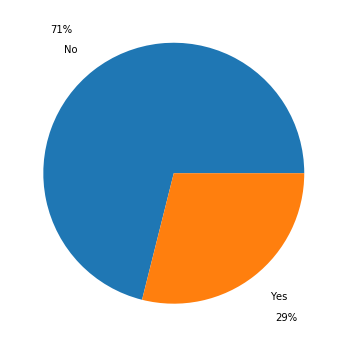

In [19]:
plt.rcParams["figure.figsize"] = (6,6)
plt.pie(topiechart['contributors_relation'], labels=topiechart['relation'], autopct='%1.0f%%', pctdistance=1.4, labeldistance=1.2)


## Number of comments on dependent packages

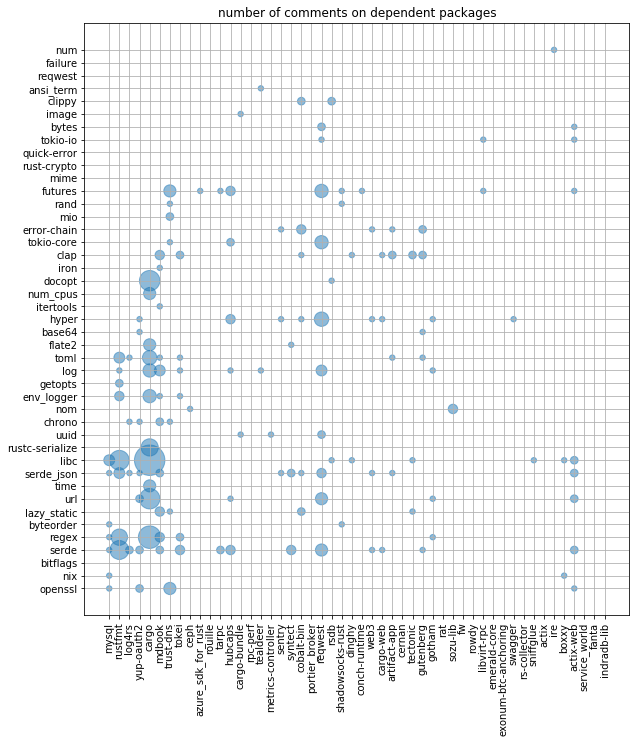

In [20]:
plt.rcParams["figure.figsize"] = (9,9)
fig, ax = plt.subplots()
ax.scatter(selected_packages['package'],selected_packages['target'], s=selected_packages.cnr_relation_count*30, alpha=0.5)
ax.set_title('number of comments on dependent packages')
ax.grid(True)
fig.tight_layout()
plt.xticks(rotation=90)

plt.show()

# Question 1

Are contributors of comments (commit comments, issue comments, pull request comments) more likely to contribute to packages they depend on (or to packages that depend on them) than to other packages?

*** I think to answer this question we need all comments of users who have contributed on a package... to this end, we need to scrap github to find all comments of a user

# Question 2

Is there some (temporal) relation between the commenting activity and the decision to start "depending on" a package? For example, if you are a developer of some package, and you would like to start depending on another package, you might first start to be involved through comments in that package, before you actually make the decision to depend on it. Such a possible relation could probably be checked using the statistical technique of "survival analysis".

*** I found some relations but I need to study survival analysis to answer this question better

In [131]:
packages_dependencies = packages.merge(dependencies,left_on=['package','version'], right_on=['package','version'])

In [132]:
all_comments_name = all_comments.merge(repos.reset_index(),left_on='project_name', right_on='Repository_URL')[['Name','user_login','author_assoc','created_at','type']]
all_comments_name = all_comments_name[all_comments_name['author_assoc'] != 'NONE'][all_comments_name['author_assoc'] != 'MEMBER']

In [133]:
pkg_dep_cntbr_cmnt = packages_dependencies.drop_duplicates(subset=['package','target'],keep = 'first')

In [36]:
def check_comments(row):
    contributors = all_comments_name[all_comments_name['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments_name[all_comments_name['Name'] == row['target']][all_comments_name['user_login'].isin(contributors)][all_comments_name['created_at'] < row['date']]
    return cont_depends.user_login.unique()

pkg_dep_cntbr_cmnt['contributor_commented_before_use'] = pkg_dep_cntbr_cmnt.apply(lambda row: check_comments(row),axis=1)

In [37]:
pkg_dep_cntbr_cmnt['contributor_commented_before_use_count'] = pkg_dep_cntbr_cmnt.apply(lambda row: len(row['contributor_commented_before_use']),axis=1)

In [54]:
cmtpckg = pkg_dep_cntbr_cmnt[pkg_dep_cntbr_cmnt['contributor_commented_before_use_count'] >0].sort_values('date')

In [59]:
pkg_dep_cntbr_cmnt.sort_values('date',inplace=True)

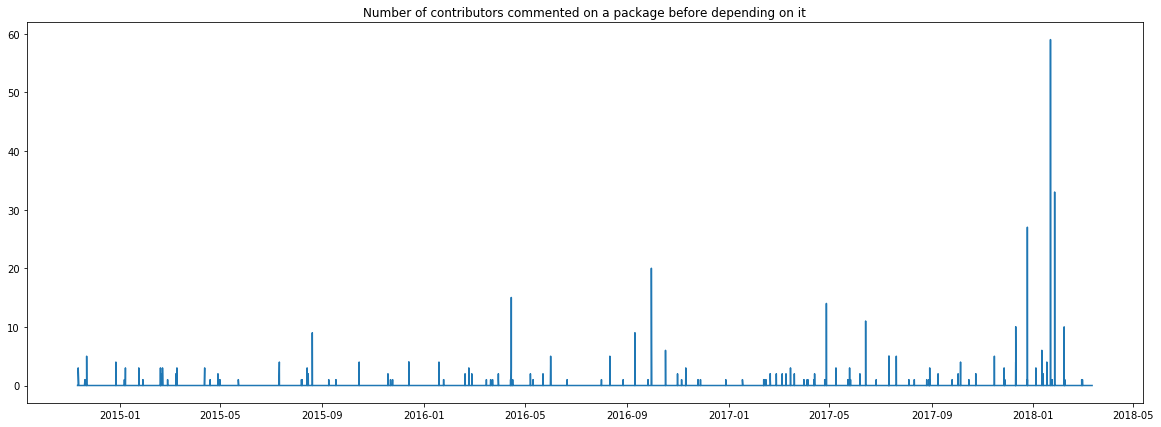

In [61]:
plt.rcParams["figure.figsize"] = (20,7)
fig, ax = plt.subplots()
ax.plot(pkg_dep_cntbr_cmnt['date'], pkg_dep_cntbr_cmnt['contributor_commented_before_use_count'])
ax.set_title('Number of contributors commented on a package before depending on it')
plt.show()

# Question 3

Is there some (temporal) relation between the commenting activity and the decision to start “contributing to" a package? I would guess that new contributors/committers to the code of a package would first start by commenting to the package, and as they get more experiences they might go one step further and actually start submitting pull requests or even direct commits (depending on the development process followed)

*** To answer this question we need to extract commits or pull requests of users on packages (we already have commit data)

# Question 4

Is there some relation between the commenting activity and the decision to stop “depending on” / “contributing to” a package? People may get dissatisfied with some package. In that case, they might either suddenly discontinue using/contributing to that package, or there may be “early signs” of this dissatisfaction in terms of their commenting activity.

*** I will answer it tomorrow

# Temoprary Test codes

In [26]:
packages_dependencies_sentry = packages_dependencies[packages_dependencies['package']=='sentry']
packages_dependencies_sentry['date'] = pandas.to_datetime(packages_dependencies_sentry['date'])
pkg_dpnd_cmts = packages_dependencies_sentry.merge(all_comments_name,left_on='package',right_on='Name')

In [33]:
packages_dependencies_sentry = packages_dependencies_sentry.sort_values('date').drop_duplicates(subset='target',keep = 'first')

In [28]:
#[['package','version','date','target','constraint','Name','user_login','author_assoc','created_at']]
import datetime
date = datetime.date(year=2017,month=7,day=10)
print(date)
all_comments_name['created_at'] = pandas.to_datetime(all_comments_name['created_at'])
all_comments_sentry = all_comments_name[all_comments_name['Name'].isin(['sentry'])]
all_comments_sentry_depend = all_comments_name[all_comments_name['Name'].isin(packages_dependencies_sentry.target.unique())]

2017-07-10


In [29]:
packages_dependencies_sentry.target.unique()

array(['time', 'chrono', 'hyper', 'backtrace', 'hyper-native-tls', 'log',
       'url', 'tokio-core', 'serde_json', 'serde_derive', 'serde',
       'hyper-tls', 'futures', 'error-chain'], dtype=object)

In [30]:
all_comments_sentry.head()

,Name,user_login,author_assoc,created_at,type
150771,sentry,bbigras,CONTRIBUTOR,2018-06-18 17:18:04,isu
150811,sentry,aagahi,CONTRIBUTOR,2017-10-25 04:59:02,isu
150821,sentry,bbigras,CONTRIBUTOR,2018-10-03 15:54:26,isu
150823,sentry,aagahi,CONTRIBUTOR,2017-09-25 10:30:01,isu
150824,sentry,yjh0502,CONTRIBUTOR,2017-10-11 07:45:54,isu


In [31]:
contributors = all_comments_name[all_comments_name['Name'] == 'sentry'].user_login.unique()

In [32]:
all_comments_sentry_depend[all_comments_sentry_depend['Name'] =='error-chain'][all_comments_sentry_depend['user_login'].isin(contributors)]

,Name,user_login,author_assoc,created_at,type
77037,error-chain,king6cong,CONTRIBUTOR,2017-06-09 04:03:49,pul
